# Using a State-Of-The-Art (SOTA) GANs

In this exercise you will get to experiment with some modern and best-in-class GANs.

These GANs have been built with the [StyleGAN-3](https://nvlabs.github.io/stylegan3/) system by NVIDIA. Since here we will only use them for inference - no training necessary - we will not need a lot of code.

Let's start by importing all the modules we will need:

In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import torch

Now we can load one of the models. There are several GANs available for use directly from the authors. You can find the full list [here](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/research/models/stylegan3/files).

For this exercise, we are going to experiment with a StyleGAN trained on the [Animal Faces-HQ](https://paperswithcode.com/dataset/afhq) dataset. It can generate unconditionally images of animals.

Let's load the model. In this case, the authors decided to export their models in a special pickle file containing all the needed code:

> NOTE: in order to use it on your own, remember to download the [StyleGAN3](https://github.com/NVlabs/stylegan3) repo and put it in your PYTHONPATH or do this:

In [2]:
# Add styleGAN3 repo to the paths where python
# searches for modules
import sys
sys.path.append("/home/student/stylegan3")

In [3]:
with open('/home/student/.cache/dnnlib/downloads/20755e1ffb4380580e4954f8b0f9e630_stylegan3-r-afhqv2-512x512.pkl', 'rb') as f:
    stylegan_model = pickle.load(f)

Let's look at what's inside:

In [4]:
stylegan_model.keys()

dict_keys(['training_set_kwargs', 'G', 'D', 'G_ema', 'augment_pipe', 'kwargs'])

Can you guess what do the `G` and `D` stand for here?

> **YOUR ANSWER HERE**

What about `G_ema`?

> **YOUR ANSWER HERE**

We can ignore the rest of the keys. Ok, so let's get the Exponential Moving Average Generator then:

In [5]:
G = stylegan_model['G_ema'] # YOUR CODE HERE
G

Generator(
  (synthesis): SynthesisNetwork(
    w_dim=512, num_ws=16,
    img_resolution=512, img_channels=3,
    num_layers=14, num_critical=2,
    margin_size=10, num_fp16_res=4
    (input): SynthesisInput(
      w_dim=512, channels=1024, size=[36, 36],
      sampling_rate=16, bandwidth=2
      (affine): FullyConnectedLayer(in_features=512, out_features=4, activation=linear)
    )
    (L0_36_1024): SynthesisLayer(
      w_dim=512, is_torgb=False,
      is_critically_sampled=False, use_fp16=False,
      in_sampling_rate=16, out_sampling_rate=16,
      in_cutoff=2, out_cutoff=2,
      in_half_width=6, out_half_width=6,
      in_size=[36, 36], out_size=[36, 36],
      in_channels=1024, out_channels=1024
      (affine): FullyConnectedLayer(in_features=512, out_features=1024, activation=linear)
    )
    (L1_36_1024): SynthesisLayer(
      w_dim=512, is_torgb=False,
      is_critically_sampled=False, use_fp16=False,
      in_sampling_rate=16, out_sampling_rate=16,
      in_cutoff=2, out_c

We can see that the Generator network here is a lot more complex than what we used in our exercise from scratch. You can refere to the StyleGAN3 repo and paper for details.

We won't need it for generating, but just for fun, let's also get the Discriminator network and have a look at it:

In [6]:
D = stylegan_model['D'] # YOUR CODE HERE
D

Discriminator(
  c_dim=0, img_resolution=512, img_channels=3
  (b512): DiscriminatorBlock(
    resolution=512, architecture=resnet
    (fromrgb): Conv2dLayer(in_channels=3, out_channels=64, activation=lrelu, up=1, down=1)
    (conv0): Conv2dLayer(in_channels=64, out_channels=64, activation=lrelu, up=1, down=1)
    (conv1): Conv2dLayer(in_channels=64, out_channels=128, activation=lrelu, up=1, down=2)
    (skip): Conv2dLayer(in_channels=64, out_channels=128, activation=linear, up=1, down=2)
  )
  (b256): DiscriminatorBlock(
    resolution=256, architecture=resnet
    (conv0): Conv2dLayer(in_channels=128, out_channels=128, activation=lrelu, up=1, down=1)
    (conv1): Conv2dLayer(in_channels=128, out_channels=256, activation=lrelu, up=1, down=2)
    (skip): Conv2dLayer(in_channels=128, out_channels=256, activation=linear, up=1, down=2)
  )
  (b128): DiscriminatorBlock(
    resolution=128, architecture=resnet
    (conv0): Conv2dLayer(in_channels=256, out_channels=256, activation=lrelu, up=1

The Discriminator looks a lot more like a normal Convolutional Neural Network. Note however that the output of the discriminator is 1 number with a linear activation:

```
(out): FullyConnectedLayer(in_features=512, out_features=1, activation=linear)
```
instead of a Sygmoid activation as we used before. Why? Because this is actually a Critic network more than a Discriminator network, so the output is a score for the input image, and not a class probability as in the case of the DCGAN we have seen before.

Anyway, now we are ready to generate an image.

In [7]:
z_dim = G.z_dim

# Generate a latent code with batch dimension of 1
# and latent dimension z_dim
# Remember: you can generate random numbers distributed as a 
# normal distribution using torch.randn
z = torch.randn([1, z_dim]) # YOUR CODE HERE

Now let's move everything to the GPU:

In [10]:
z = z.to("cuda")
G = G.to("cuda")

Great, now call the Generator network:

> NOTE: StyleGAN3 can also be class-conditioned, i.e., conditioned to generate a specific class in the dataset. This model we are using is not, so our class tensor will just be None

In [11]:
c = None
# Call the Generator passing in the latent.
img = G(z, c) # YOUR CODE HERE

Setting up PyTorch plugin "bias_act_plugin"... Setting up PyTorch plugin "filtered_lrelu_plugin"... 

The image generated by the network contains values distributed more or less in the range -1 to +1, but not exactly. We need to convert that to a RGB image and trucante the values that are outside of the range. We can do all of that like this:

In [ ]:
# From batch, bgr to batch, RGB
rgb_img = img.permute(0, 2, 3, 1)

# Convert to the RGB range then cut values outside of the range
rgb_img = (rgb_img * 127.5 + 128).clamp(0, 255)

# Now convert to unsigned integers and move to CPU, so we can display
rgb_img = rgb_img.to(torch.uint8).cpu()

(-0.5, 511.5, 511.5, -0.5)

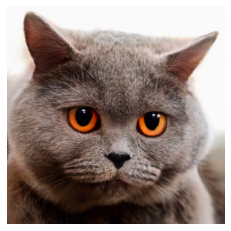

In [13]:
plt.imshow(rgb_img.squeeze(dim=0))
plt.axis("off")

Now generate a few more images:

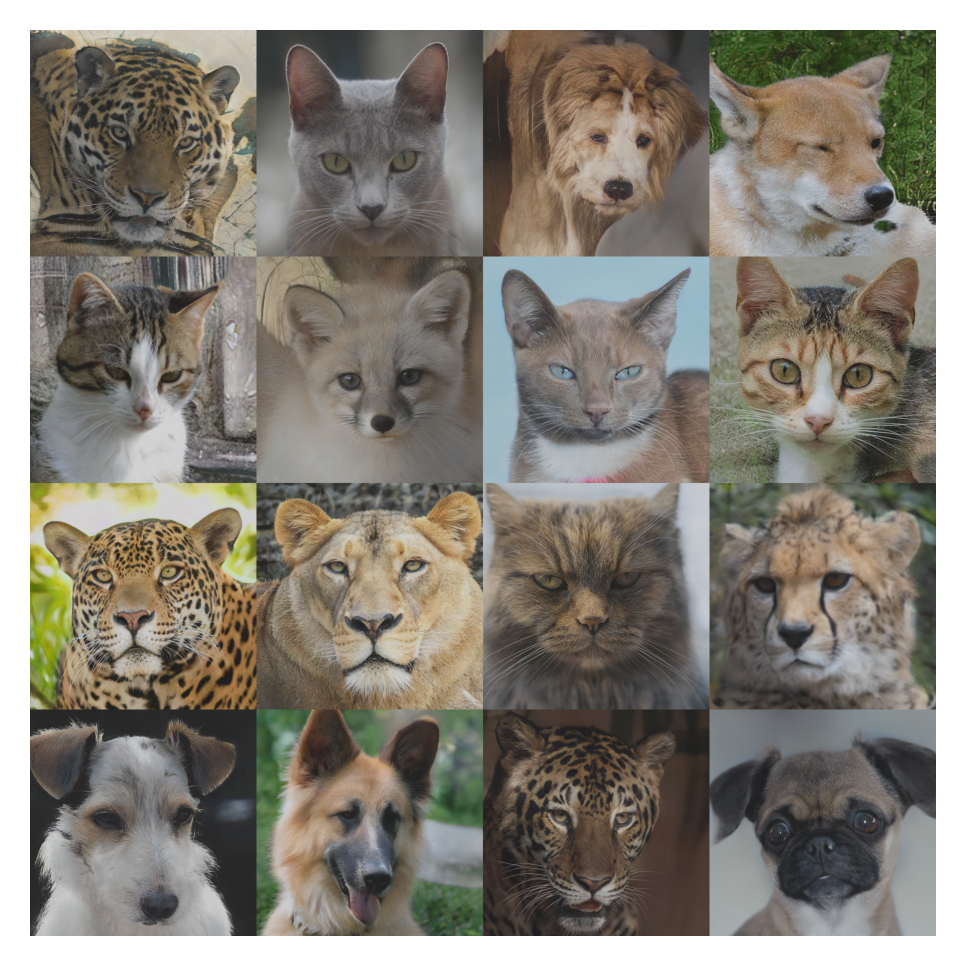

In [21]:
# YOUR CODE HERE
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np


z = torch.randn([16, z_dim]).cuda()

imgs = G(z, c) 

fig, sub = plt.subplots(dpi=300)
sub.imshow(
    np.transpose(
        make_grid(
            imgs, 
            padding=0,
            normalize=True,
            nrow=4,
        ).cpu(),
        (1,2,0)
    )
)
_ = sub.axis("off")

Look the details here! The fur and all the other details are reproduced almost flawlessly.